## Introduction

In the past few years the amount of users of social media has grown tremendously. People from around the world can read other people's posts about tips and ideas in a few seconds, including renown celebrities and politicians. The natural question arises: to what extent does these posts from famous people impact a stock price? To delve into our question we will be analyzing tweets from Twitter, currently known as X. 

#### We have to write about how and what models we are going to use to analyze these insights.

For stock information we use data from yfinance.

In [1]:
!pip install yfinance # run this code to be able to access yfinance library.

In [2]:
!pip install nltk

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Some libraries I thought we would need to use.
# Please feel free to add more that are needed

We create a function that cleans the content of the tweet, since there irrelevant information.

In [4]:
# Clean the 'Tweets' column
def clean_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove special characters, numbers, punctuations (except for the ' character which might be used in words like don't)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # Remove multiple spaces if any
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
musk_data = pd.read_csv("elonmusk.csv")

In [6]:
musk_data.head()

Tweets  Retweets   Likes  \
0                             @PeterSchiff 🤣 thanks       209    7021   
1                             @ZubyMusic Absolutely       755   26737   
2  Dear Twitter Advertisers https://t.co/GMwHmInPAS     55927  356623   
3                                       @BillyM2k 👻       802   19353   
4    Meeting a lot of cool people at Twitter today!      9366  195546   

                  Date  
0  2022-10-27 16:17:39  
1  2022-10-27 13:19:25  
2  2022-10-27 13:08:00  
3  2022-10-27 02:32:48  
4  2022-10-26 21:39:32

In [7]:
musk_data['Date'] = pd.to_datetime(musk_data['Date'])

# Apply the cleaning function to the 'Tweets' column
musk_data['Tweets'] = musk_data['Tweets'].apply(clean_tweet)

# Normalize the text to lowercase
musk_data['Tweets'] = musk_data['Tweets'].str.lower()

musk_data.columns = musk_data.columns.str.lower()

# Make a copy of the data set
musk = musk_data.copy()

# Show the cleaned DataFrame head
musk_data.head()

tweets  retweets   likes  \
0                                         thanks       209    7021   
1                                     absolutely       755   26737   
2                       dear twitter advertisers     55927  356623   
3                                                      802   19353   
4  meeting a lot of cool people at twitter today      9366  195546   

                 date  
0 2022-10-27 16:17:39  
1 2022-10-27 13:19:25  
2 2022-10-27 13:08:00  
3 2022-10-27 02:32:48  
4 2022-10-26 21:39:32

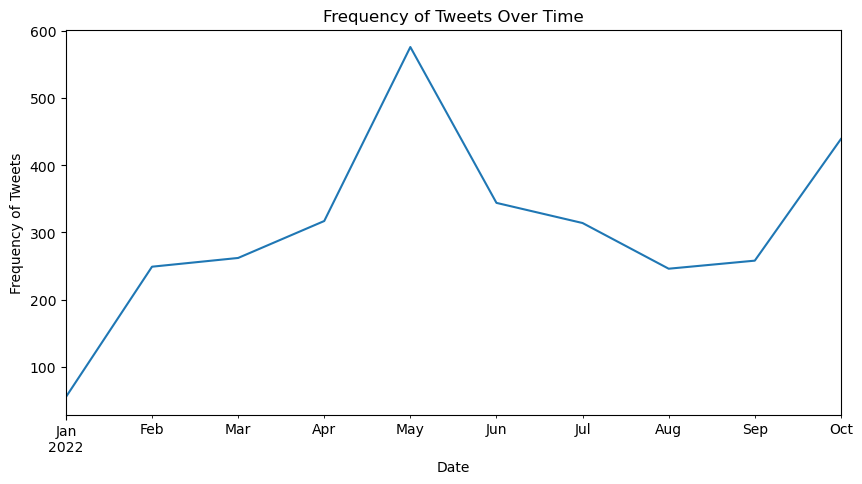

In [8]:
musk_data.set_index('date', inplace=True)

frequency = musk_data.resample('M').size()

plt.figure(figsize=(10,5))
frequency.plot()

plt.xlabel('Date')
plt.ylabel('Frequency of Tweets')
plt.title('Frequency of Tweets Over Time')

plt.show()

## Elon Musk Tweet's impact on Tesla Stock Price

 Let's look at a specific use case of one of Elon Musk's tweets on the change in Tesla's stock price. It is difficult to analyze causation from a single tweet's impact on the stock price, however, there is enough of a significant impact and correlation that it should be referenced. 

On November 6th 2021, Elon Musk tweeted a poll that said "Much is made lately of unrealized gains being a means of tax avoidance, so I propose selling 10% of my Tesla stock. Do you support this?" The tweet had a yes or no poll where his followers could show their "support" in selling his Tesla stock. Elon Musk tweeted this on a Saturday (the stock market was not open). Let's look at how this tweet had an impact on Tesla stock price before and after he tweeted on November 6th. 

In [9]:
# Since November 6, 2021 was a Saturday, we'll look at data from the surrounding days
start_date = "2021-11-04"  # Friday before the tweet
end_date = "2021-11-09"    # Monday after the tweet

tickers = ['TSLA']

df_list = []

for ticker in tickers:
    # Download data for the specified date range
    data = yf.download(ticker, start=start_date, end=end_date)
    df_list.append(data)

df = pd.concat(df_list, keys=tickers, names=['Ticker', 'Date'])
df = df.reset_index()

# Print the head of the dataframe to check the first few rows
df.head()


[*********************100%%**********************]  1 of 1 completed


Ticker       Date        Open        High         Low       Close  \
0   TSLA 2021-11-04  411.470001  414.496674  405.666656  409.970001   
1   TSLA 2021-11-05  409.333344  413.290009  402.666656  407.363342   
2   TSLA 2021-11-08  383.263336  399.000000  377.666656  387.646667   

    Adj Close     Volume  
0  409.970001   76192200  
1  407.363342   64886400  
2  387.646667  100337100

Here we can see that stock price was around 407 dollars a share on November 5th(before tweet) and 388 dollars a share on November 8th(after tweet). We can also see a substantial increase in shares traded per day. This could infer that there is a lot of selling pressure of Tesla stock during this time. 

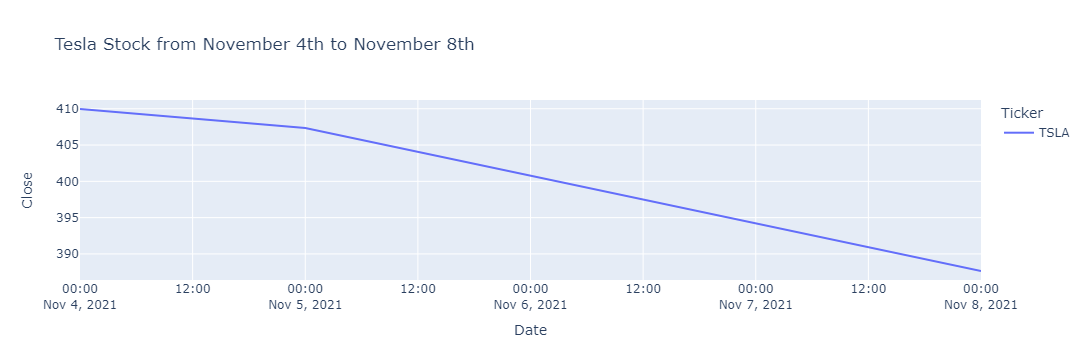

In [10]:
fig = px.line(df, x='Date', 
              y='Close', 
              color='Ticker', 
              title="Tesla Stock from November 4th to November 8th")
fig.show()

It's possible that the decrease in Tesla stock could be due to overall market conditions and not Elon Musk's tweet. We found another stock, Lucid Group, that is highly correlated to Tesla. Lucid Group is an American manufacturer of luxury electric vehicles which is the same market as Tesla. Let's look at the stock price of Lucid during the same time frame of before and after Elon Musk's tweet. 

In [11]:
start_date = "2021-11-04" 
end_date = "2021-11-09" 

tickers = ['LCID']

df_list = []

for ticker in tickers:
    # Download data for the specified date range
    data = yf.download(ticker, start=start_date, end=end_date)
    df_list.append(data)

df_lucid = pd.concat(df_list, keys=tickers, names=['Ticker', 'Date'])
df_lucid = df.reset_index()

# Print the head of the dataframe to check the first few rows
df_lucid.head()


[*********************100%%**********************]  1 of 1 completed


index Ticker       Date        Open        High         Low       Close  \
0      0   TSLA 2021-11-04  411.470001  414.496674  405.666656  409.970001   
1      1   TSLA 2021-11-05  409.333344  413.290009  402.666656  407.363342   
2      2   TSLA 2021-11-08  383.263336  399.000000  377.666656  387.646667   

    Adj Close     Volume  
0  409.970001   76192200  
1  407.363342   64886400  
2  387.646667  100337100

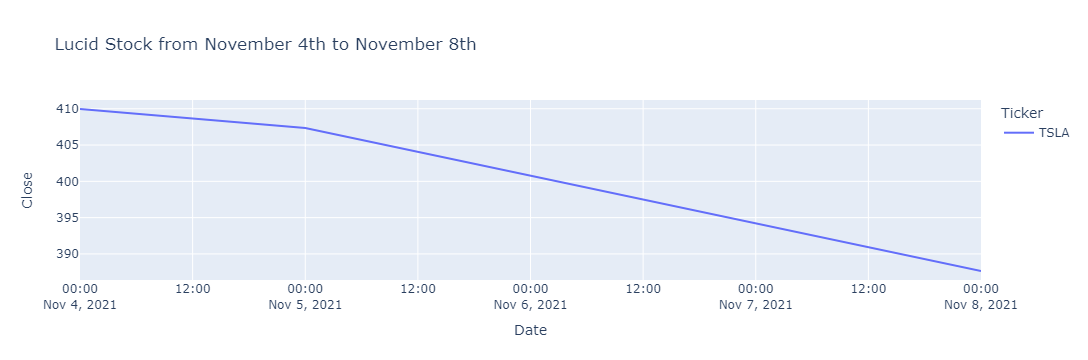

In [12]:
fig = px.line(df_lucid, x='Date', 
              y='Close', 
              color='Ticker', 
              title=" Lucid Stock from November 4th to November 8th")
fig.show()

As we can see, Lucid stock had an almost opposite effect as Tesla. The price increased a substantial amount from before and after Elon Musk's tweet. Next, let's run a correlation test to see how correlated the two stocks are. We'll run a correlation test for all of 2021 for the sake of simplicity. 

In [13]:
tickers = ['TSLA', 'LCID']


start_date = '2021-01-01'
end_date = '2021-12-31'


data = yf.download(tickers, start=start_date, end=end_date)


closing_prices = data['Close']

correlation_matrix = closing_prices.corr()

correlation_matrix

[*********************100%%**********************]  2 of 2 completed


Ticker      LCID      TSLA
Ticker                    
LCID    1.000000  0.681639
TSLA    0.681639  1.000000

Therefore, the two stocks are usually positively correlated so it is strange that two stocks move in opposite directions from November 5th to 8th. Let's create a visualization to show the movement clearer. 

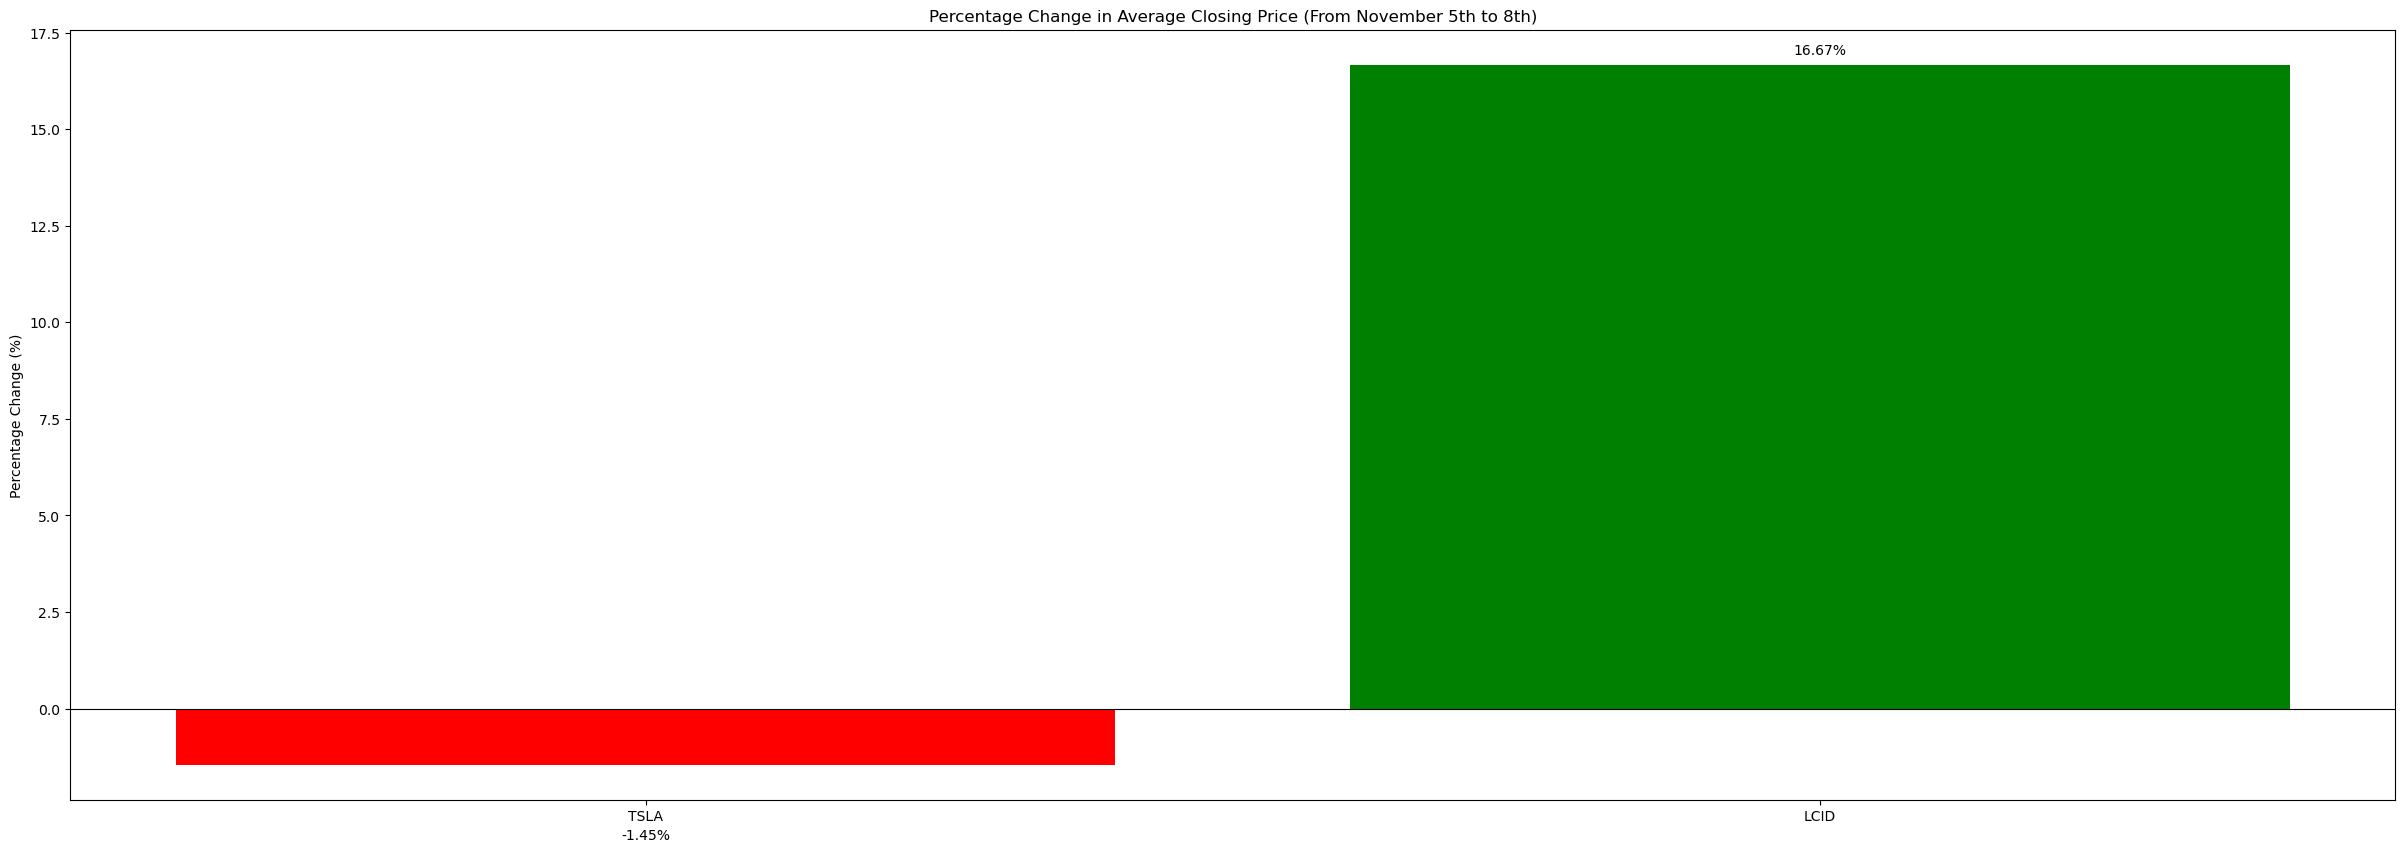

In [14]:

avg_price_before_tsla = 1033.42
avg_price_after_tsla = 1018.43
avg_price_before_lcid = 39.36
avg_price_after_lcid = 45.92

percent_change_tsla = ((avg_price_after_tsla - avg_price_before_tsla) / avg_price_before_tsla) * 100
percent_change_lcid = ((avg_price_after_lcid - avg_price_before_lcid) / avg_price_before_lcid) * 100


companies = ['TSLA', 'LCID']
percent_changes = [percent_change_tsla, percent_change_lcid]

plt.figure(figsize=(30, 10))
plt.bar(companies, percent_changes, color=['red', 'green'])
plt.title('Percentage Change in Average Closing Price (From November 5th to 8th)')
plt.ylabel('Percentage Change (%)')
plt.axhline(0, color='black', linewidth=0.8)

for i, v in enumerate(percent_changes):
    plt.text(i, v + (0.2 if v >= 0 else -2), f"{v:.2f}%", ha='center', va='bottom')


plt.show()

In [15]:
trump_data = pd.read_csv("trumptweets.csv")
trump_data.head()

id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 20:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-05 03:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 15:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 22:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 16:07:28   

   retweets  favorites mentions hashtags  geo  
0       500        868      NaN      NaN  NaN  
1        33        273      NaN      NaN  NaN  
2        12         18      NaN      NaN  NaN  
3        11         24      NaN      NaN  NaN  
4      1399       1965      NaN      NaN  NaN

We clean the 'trump' data so that it matches the format of 'musk' data. 

In [16]:
trump_data['date'] = pd.to_datetime(trump_data['date'])

# Clean the 'content' column
trump_data['content'] = trump_data['content'].apply(clean_tweet)

# Rename columns
trump_data.rename(columns={'content': 'tweet', 'favorites': 'likes'}, inplace=True)

# Select only the required columns
trump_data = trump_data[['tweet', 'retweets', 'likes', 'date']]

# Copy the data set for future uses.

trump = trump_data.copy()

# Display the cleaned and updated DataFrame
trump_data.head()

tweet  retweets  likes  \
0  Be sure to tune in and watch Donald Trump on L...       500    868   
1  Donald Trump will be appearing on The View tom...        33    273   
2  Donald Trump reads Top Ten Financial Tips on L...        12     18   
3  New Blog Post Celebrity Apprentice Finale and ...        11     24   
4  My persona will never be that of a wallflower ...      1399   1965   

                 date  
0 2009-05-04 20:54:25  
1 2009-05-05 03:00:10  
2 2009-05-08 15:38:08  
3 2009-05-08 22:40:15  
4 2009-05-12 16:07:28

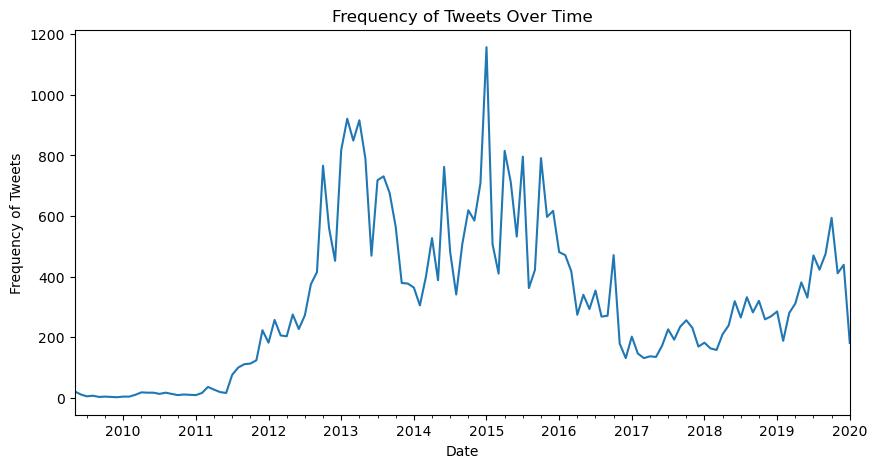

In [17]:
trump_data.set_index('date', inplace=True)

frequency = trump_data.resample('M').size()

plt.figure(figsize=(10,5))
frequency.plot()

plt.xlabel('Date')
plt.ylabel('Frequency of Tweets')
plt.title('Frequency of Tweets Over Time')

plt.show()

Now that we have cleaned the data and observed a visualization, the frequency of tweets, we present the stock and it's history that are related to each person.


#### Write about each person and the stock they are related. What and why would be sufficient.

Since the date range for Donald Trump does not coincide with Trump Media, we use the S&P 500 index for a proxy of Trump's influence.

In [18]:
musk_recent_date = musk['date'].max()
musk_oldest_date = musk['date'].min()

trump_recent_date = trump['date'].max()
trump_oldest_date = trump['date'].min()

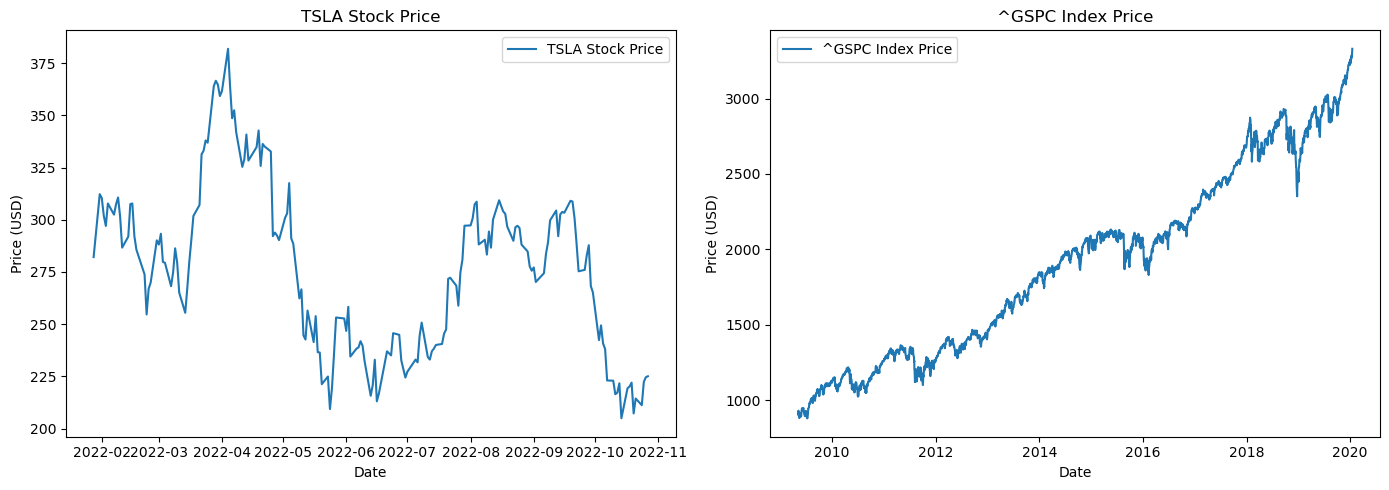

In [19]:
# Define the tickers
musk_ticker = 'TSLA'  # Tesla for Elon Musk
trump_ticker = '^GSPC'  # S&P 500 index as a proxy for Donald Trump

# Fetch the historical stock data
musk_data = yf.Ticker(musk_ticker)
trump_data = yf.Ticker(trump_ticker)

# Get the historical closing prices
musk_df = musk_data.history(period='1d', start=musk_oldest_date, end=musk_recent_date)
trump_df = trump_data.history(period='1d', start=trump_oldest_date, end=trump_recent_date)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot Elon Musk-related stock data
axes[0].plot(musk_df['Close'], label=f'{musk_ticker} Stock Price')
axes[0].set_title(f'{musk_ticker} Stock Price')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Plot Donald Trump-related index data
axes[1].plot(trump_df['Close'], label=f'{trump_ticker} Index Price')
axes[1].set_title(f'{trump_ticker} Index Price')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()

# Show the plots side by side
plt.tight_layout()
plt.show()


The range of S&P 500 looks too wide, making it difficult to observe the volatility and impacts. Hence, we shorten the range that coincides with Trump's serving years as the president of the United States. (2017 - 2021)

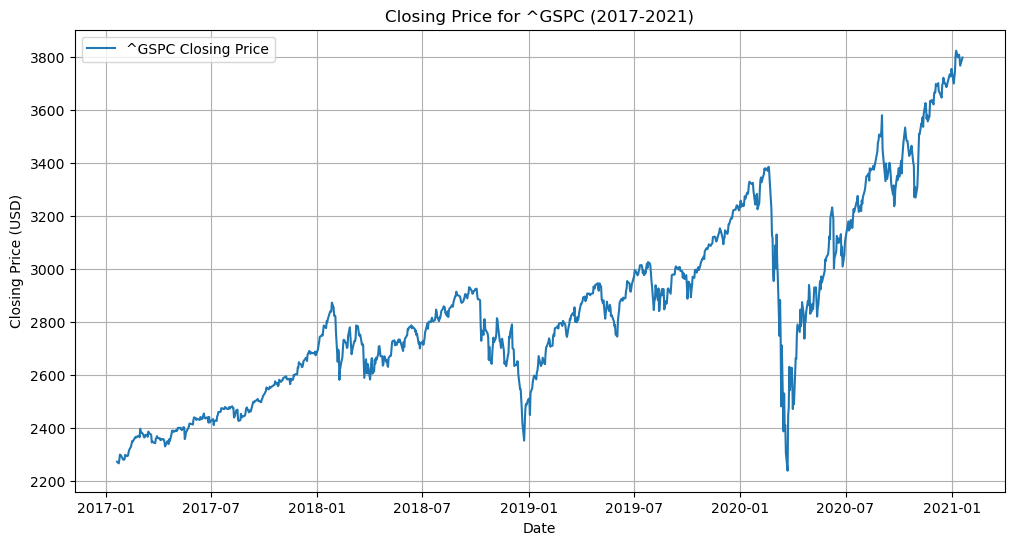

In [20]:
trump_ticker = '^GSPC'  # S&P 500 index as a proxy for Donald Trump
trump_data = yf.Ticker(trump_ticker)
trump_df = trump_data.history(period='1d', start='2017-01-20', end='2021-01-20')


# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(trump_df.index, trump_df['Close'], label=f'{trump_ticker} Closing Price')
plt.title(f'Closing Price for {trump_ticker} (2017-2021)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Now that we have seen that our visualization and data are ready, we start by analyzing the tweets by using sentiment analysis. 

We are going to measure the average monthly sentiment for the tweets and compare it with the monthly stock price. Moreover, try to analyze the impact based on the sentiment score.

In [21]:
# Ensure you've downloaded the VADER lexicon
nltk.download('vader_lexicon')

# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Create a new column for sentiment scores
musk['sentiment'] = musk['tweets'].apply(lambda x: sia.polarity_scores(x)['compound'])
trump['sentiment'] = trump['tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])
# Now, you have sentiment scores for each tweet ranging from -1 (negative) to +1 (positive)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
musk.head()

tweets  retweets   likes  \
0                                         thanks       209    7021   
1                                     absolutely       755   26737   
2                       dear twitter advertisers     55927  356623   
3                                                      802   19353   
4  meeting a lot of cool people at twitter today      9366  195546   

                 date  sentiment  
0 2022-10-27 16:17:39     0.4404  
1 2022-10-27 13:19:25     0.0000  
2 2022-10-27 13:08:00     0.3818  
3 2022-10-27 02:32:48     0.0000  
4 2022-10-26 21:39:32     0.3182

In [23]:
trump.head()

tweet  retweets  likes  \
0  Be sure to tune in and watch Donald Trump on L...       500    868   
1  Donald Trump will be appearing on The View tom...        33    273   
2  Donald Trump reads Top Ten Financial Tips on L...        12     18   
3  New Blog Post Celebrity Apprentice Finale and ...        11     24   
4  My persona will never be that of a wallflower ...      1399   1965   

                 date  sentiment  
0 2009-05-04 20:54:25     0.4767  
1 2009-05-05 03:00:10     0.7506  
2 2009-05-08 15:38:08     0.6115  
3 2009-05-08 22:40:15     0.0000  
4 2009-05-12 16:07:28     0.0000

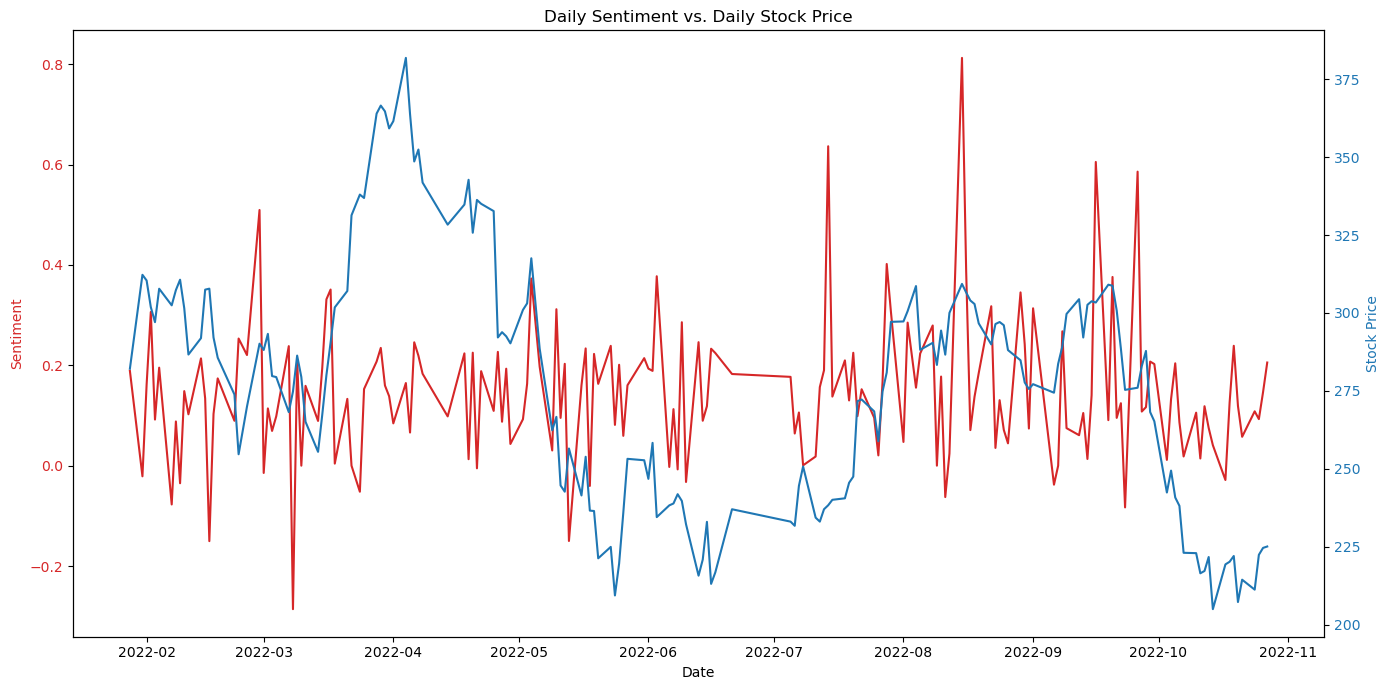

Correlation between daily sentiment and stock price: 0.048321607269304415


In [24]:
# Define the tickers
musk_ticker = 'TSLA'  # Tesla for Elon Musk

# Fetch the historical stock data
musk_data = yf.Ticker(musk_ticker)

# Get the historical closing prices
musk_df = musk_data.history(period='1d', start=musk_oldest_date, end=musk_recent_date)

# Reset the index to turn the date index into a column
musk_df.reset_index(inplace=True)

musk_df['Date'] = musk_df['Date'].dt.tz_localize(None)

# To get rid of the seconds behind the dates
musk['date'] = musk['date'].dt.normalize()

# Since there are several tweets for a single day we compute the daily mean for the sentiment score. 
daily_average_sentiment = musk.groupby('date')['sentiment'].mean().reset_index()


# Now you can merge without the timezone error
combined_data = pd.merge(daily_average_sentiment, musk_df, left_on='date', right_on='Date', how='inner')

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(combined_data['Date'], combined_data['sentiment'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Stock Price', color=color)  
ax2.plot(combined_data['Date'], combined_data['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Daily Sentiment vs. Daily Stock Price')
fig.tight_layout()  # to make sure nothing is cut off
plt.show()

# Correlation calculation
correlation = combined_data['sentiment'].corr(combined_data['Close'])
print(f"Correlation between daily sentiment and stock price: {correlation}")

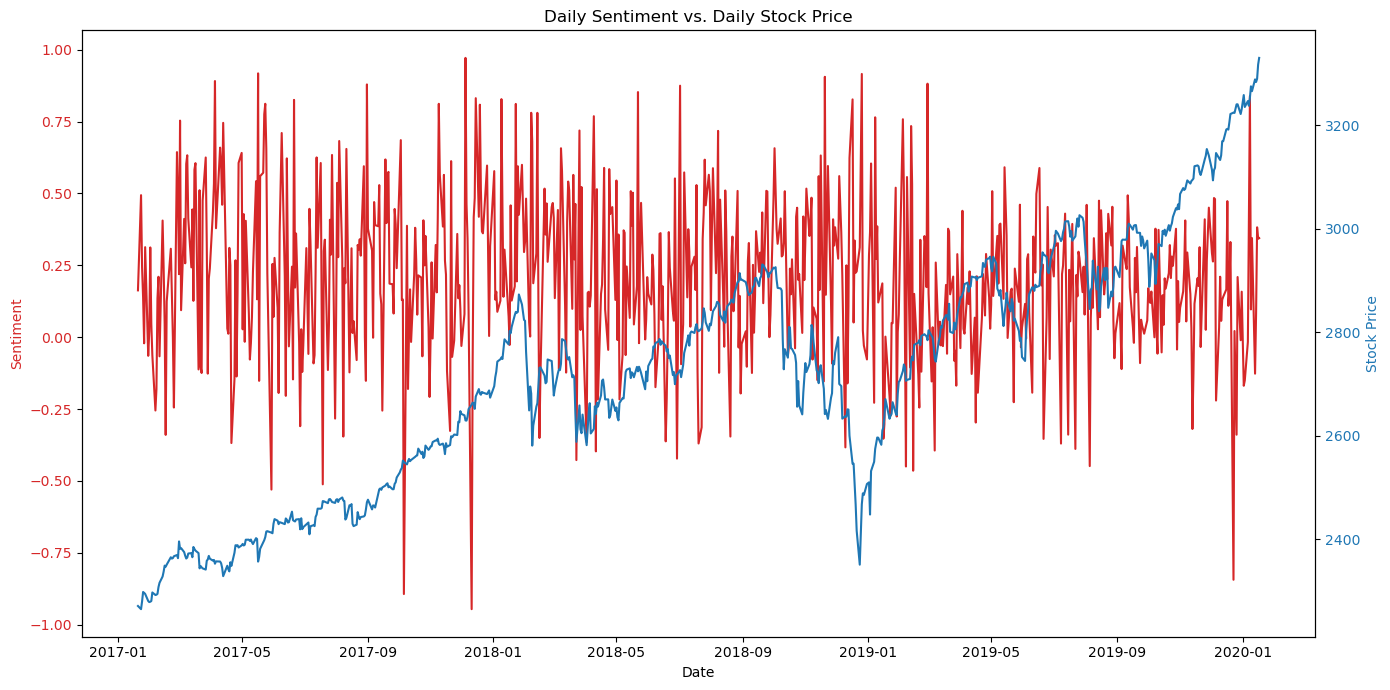

Correlation between daily sentiment and stock price: -0.08777619129235141


In [25]:
# Define the tickers
trump_ticker = '^GSPC'  # S&P 500 index as a proxy for Donald Trump

trump_data = yf.Ticker(trump_ticker)

# Get the historical closing prices
trump_df = trump_data.history(period='1d', start='2017-01-20', end='2021-01-20')

# Reset the index to turn the date index into a column
trump_df.reset_index(inplace=True)

trump_df['Date'] = trump_df['Date'].dt.tz_localize(None)

# Filter the DataFrame for the date range
mask_trump = (trump['date'] >= '2017-01-20') & (trump['date'] <= '2021-01-20')
filtered_trump = trump.loc[mask_trump]
new_trump = filtered_trump.copy()

# To get rid of the seconds behind the dates
new_trump['date'] = new_trump['date'].dt.normalize()

# Since there are several tweets for a single day we compute the daily mean for the sentiment score. 
trump_daily_average_sentiment = new_trump.groupby('date')['sentiment'].mean().reset_index()

# Now you can merge without the timezone error
trump_combined_data = pd.merge(trump_daily_average_sentiment, trump_df, left_on='date', right_on='Date', how='inner')


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(trump_combined_data['Date'], trump_combined_data['sentiment'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Stock Price', color=color)  
ax2.plot(trump_combined_data['Date'], trump_combined_data['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Daily Sentiment vs. Daily Stock Price')
fig.tight_layout()  # to make sure nothing is cut off
plt.show()

# Correlation calculation
correlation = trump_combined_data['sentiment'].corr(trump_combined_data['Close'])
print(f"Correlation between daily sentiment and stock price: {correlation}")


## **Random Forest Model**
We would like to use a predictive model to understand the impact that of  social media posts from high profile people on stock market performance.
Studying the impact of tweets from influential figures like Elon Musk and Donald Trump on stock prices is increasingly important for several reasons, reflecting the intersection of social media, public perception, and financial markets. Understanding this dynamic is crucial for market participants who need to gauge the potential impact of social media on financial markets. Furthermore, traders and investors can refine their strategies by understanding how and to what extent social media influences stock prices.

To do this, we opt for the Random Forest Model due to some factors. Firstly, Random Forest is a powerful machine learning algorithm that handlies complex datasets with intricate relationships between features. Stock prices and their movements are influenced by a myriad of factors, including market sentiment, investor perceptions, and external events, often in non-linear ways. Random Forest can capture these complex, non-linear interactions between tweet characteristics (like sentiment, engagement metrics) and stock price movements without the need for extensive feature engineering or transformation. The model also reduces the risk for over-fitting, on top of providing straightforward metrics for evaluating the importance of each feature in making predictions.

At this point in time, we opt to build one model that aggregates the two high-profile individuals and their potential influence on stock prices. A single model can provide insights into the general impact of high-profile tweets on stock prices, applicable beyond just the two individuals.

Cleaning Steps:
1. Calculating average daily sentiment, sum of retweets and sum of likes per day for both individuals.
2. Normalizing the numerical variables 'sentiment', 'sum_retweets', 'sum_likes', 'Perc_Change' using MinMaxScaler() to improve performance and training stability of the model.
3. Binary enconding the variable 'source; that takes value of 'Elon Musk' and 'Donald Trump'
4. Calculating percentage change on daily closing stock prices.
5. Combining both sets.

In [26]:
#TRUMP
#daily_average_sentiment = musk.groupby('date')['sentiment'].mean().reset_index()
trump_daily_average_sentiment = new_trump.groupby('date')['sentiment'].mean().reset_index()

# Calculate the daily sum for retweets and likes
daily_sum_retweets = new_trump.groupby('date')['retweets'].sum().reset_index()
daily_sum_likes = new_trump.groupby('date')['likes'].sum().reset_index()

# Merge the daily metrics into a single DataFrame
daily_metrics = trump_daily_average_sentiment.merge(daily_sum_retweets, on='date').merge(daily_sum_likes, on='date')

# Renaming the columns to reflect that retweets and likes are sums
daily_metrics.rename(columns={'retweets': 'sum_retweets', 'likes': 'sum_likes'}, inplace=True)

trump_combined_data = pd.merge(daily_metrics, trump_df, left_on='date', right_on='Date', how='inner')

# Optionally, drop the extra 'Date' column from the stock price dataset if it's redundant
trump_combined_data.drop('Date', axis=1, inplace=True)

# Getting target outcome: pct change
trump_combined_data['Perc_Change'] = trump_combined_data['Close'].pct_change() * 100


columns_to_normalize = ['sentiment', 'sum_retweets', 'sum_likes', 'Perc_Change']

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Replace NaN values in the DataFrame with the mean of their respective columns before normalization
# This step is important because scaling does not work with NaN values
for column in columns_to_normalize:
    trump_combined_data[column] = trump_combined_data[column].fillna(trump_combined_data[column].mean())

# Fit and transform the selected columns with the scaler
trump_combined_data[columns_to_normalize] = scaler.fit_transform(trump_combined_data[columns_to_normalize])

In [27]:
#MUSK
musk_daily_average_sentiment = musk.groupby('date')['sentiment'].mean().reset_index()

# Calculate the daily sum for retweets and likes
musk_daily_sum_retweets = musk.groupby('date')['retweets'].sum().reset_index()
musk_daily_sum_likes = musk.groupby('date')['likes'].sum().reset_index()

# Merge the daily metrics into a single DataFrame
musk_daily_metrics = musk_daily_average_sentiment.merge(musk_daily_sum_retweets, on='date').merge(musk_daily_sum_likes, on='date')

# Renaming the columns to reflect that retweets and likes are sums
musk_daily_metrics.rename(columns={'retweets': 'sum_retweets', 'likes': 'sum_likes'}, inplace=True)

musk_combined_data = pd.merge(musk_daily_metrics, musk_df, left_on='date', right_on='Date', how='inner')

# Drop the extra 'Date' column from the stock price dataset if it's redundant
musk_combined_data.drop('Date', axis=1, inplace=True)

# Getting target outcome: pct change
musk_combined_data['Perc_Change'] = musk_combined_data['Close'].pct_change() * 100

columns_to_normalize = ['sentiment', 'sum_retweets', 'sum_likes', 'Perc_Change']

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Replace NaN values in the DataFrame with the mean of their respective columns before normalization
# This step is important because scaling does not work with NaN values
for column in columns_to_normalize:
    musk_combined_data[column] = musk_combined_data[column].fillna(musk_combined_data[column].mean())

# Fit and transform the selected columns with the scaler
musk_combined_data[columns_to_normalize] = scaler.fit_transform(musk_combined_data[columns_to_normalize])

Modelling steps:

- Defining X variables: sentiment, sum_retweets, sum_likes, source
- Defining Y (outcome) variable: percentage price change
- Splitting into train and test
- Cross Validating and model building in train set
- Predicting in the test set

In [28]:
#Joining the 2 datasets

musk_combined_data['source'] = 'Elon Musk'
trump_combined_data['source'] = 'Donald Trump'
combined_data = pd.concat([musk_combined_data, trump_combined_data], ignore_index=True)
combined_data['source'] = combined_data['source'].replace({'Elon Musk': 1, 'Donald Trump': 0})

In [29]:
#Random Forest model initiation
X = combined_data[['sentiment', 'sum_retweets', 'sum_likes', 'source']]
y = combined_data['Perc_Change']

#Getting X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Building model 
#Note that this is a first attempt that still needs tunning. We plan to proceed with hypterparameter tuning.
model = RandomForestRegressor(n_estimators=100, random_state=42)

#Cross validating
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive 
scores = -scores

# Results
print("MAE scores for each fold:", scores)
print("Average MAE:", scores.mean())
print("Standard Deviation of MAE:", scores.std())

#Training 
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE on the test set:", mae)

importances = model.feature_importances_
# Map these importances to the corresponding feature names and sort them
feature_importances = sorted(zip(importances, X.columns), reverse=True)
print("Feature importances:", feature_importances)

MAE scores for each fold: [0.17046678 0.0634808  0.05750512 0.07181372 0.09211901]
Average MAE: 0.09107708623901953
Standard Deviation of MAE: 0.04138482332296647
MAE on the test set: 0.07701799337439108
Feature importances: [(0.34744975357023417, 'sentiment'), (0.31296636692922436, 'sum_retweets'), (0.2721455750379837, 'sum_likes'), (0.06743830446255777, 'source')]


**Interpretation of results:**

- The machine learning model demonstrated an ability to predict stock price changes from tweets, with an average Mean Absolute Error (MAE) of 0.091 across 5-fold cross-validation, indicating predictions were off by about 9.1%. Performance varied across folds (standard deviation of 0.041) but improved on a separate test set (MAE of 0.077), suggesting good generalization. Feature importance analysis revealed 'sentiment' as the most critical predictor, followed by engagement metrics ('sum_retweets' and 'sum_likes'), highlighting the influence of tweet content and interaction. The 'source' of tweets (Musk or Trump) had a smaller, yet significant, impact, underscoring the nuanced effects of influential tweets on stock prices.

**Future Steps:**
- Model Tuning: We will tune the model's hyperparameters (e.g., n_estimators, max_depth) using techniques like GridSearchCV or RandomizedSearchCV.